## CLM-PPE LHC Biogeochemistry 
#### Updated May 25, 2023

- Assess parametric uncertainty in biogeochemical cycling
  - LAI latin hypercube ensemble


In [7]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns
import gpflow

import warnings
warnings.filterwarnings("ignore")



from SALib.sample import fast_sampler
from SALib.analyze import fast

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ;
from ppe_analysis.analysis import *
from emulation_pyfunctions import *

2023-05-25 16:01:31.454299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 16:01:31.647936: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 16:01:31.688636: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 16:01:32.446561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Load CLM-PPE

In [3]:
# load LHC post processed data
file = '/glade/u/home/djk2120/ppe_clean/postp/lhc/ccycle.ann.LHC.nc'
ds = xr.open_dataset(file)

In [4]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

### Train Biome Specific Emulators

In [5]:
# data
var = 'GPP'
t=slice(str(2005),str(2014))
ds_in = ds[var].sel(year=t).mean(dim='year')

In [8]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-05-25 16:02:04.512036: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-25 16:02:04.512096: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc53): /proc/driver/nvidia/version does not exist
2023-05-25 16:02:04.517762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


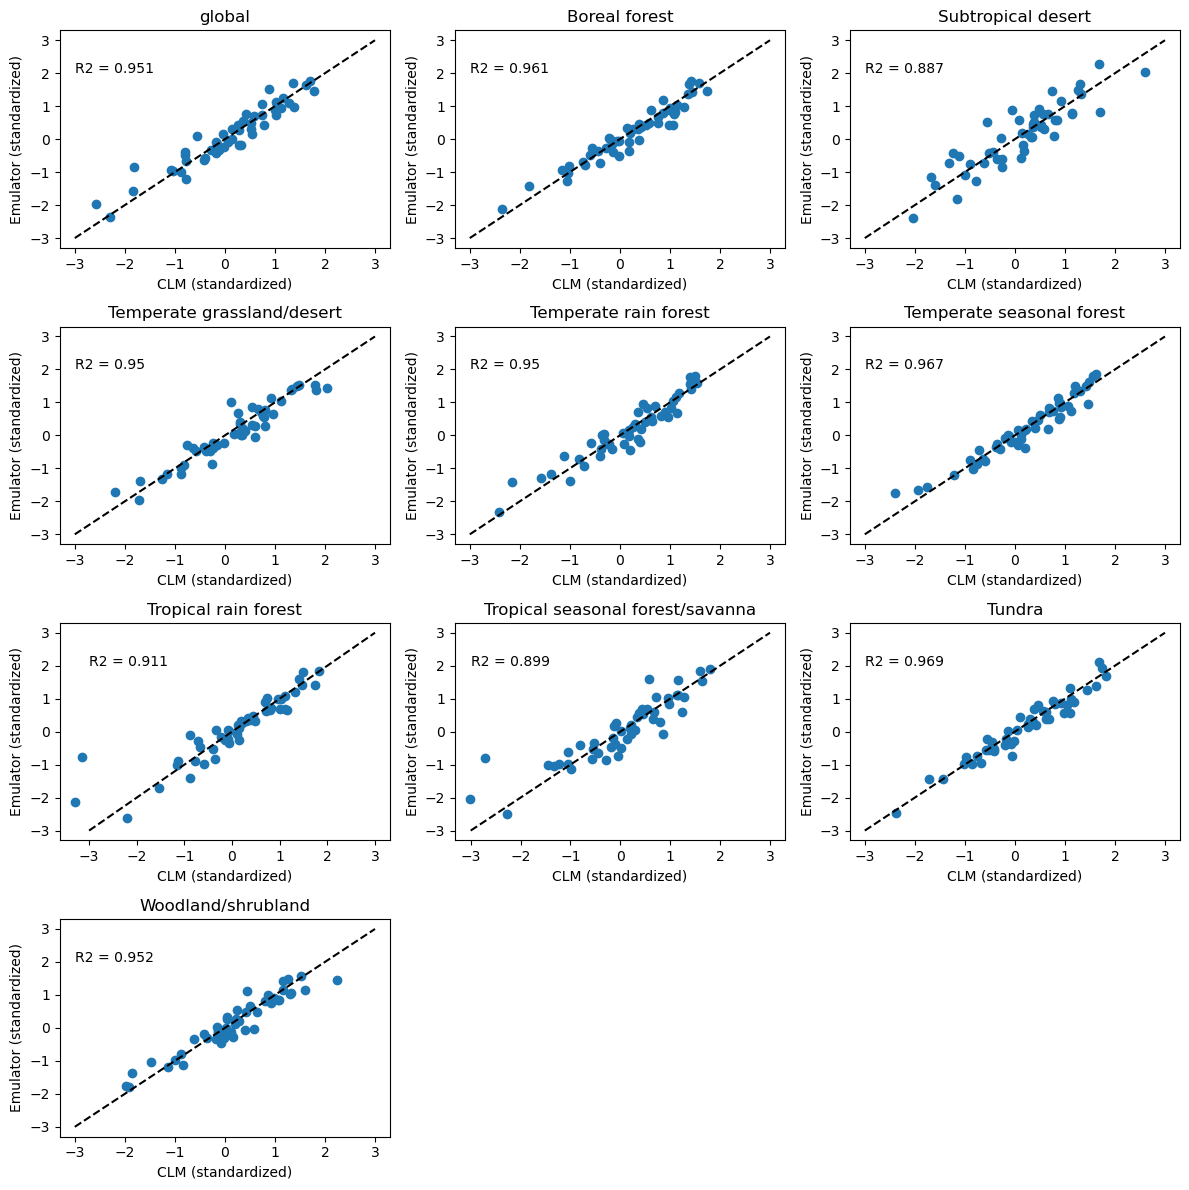

In [9]:
# train emulators and save in a dictionary 
plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 10})

BM_GPP_emulator_dict = {}
keys = ds_in.biome.values

for i,b in enumerate([0,1,3,4,5,6,7,8,9,10]):

    y_data = ds_in.isel(biome=b)
    
    ax = plt.subplot(4,3,i+1)

    emulator = train_GPemulator(y_data[1:],ppe_params,50,kernel,ax)
    
    BM_GPP_emulator_dict[keys[b]] = emulator
    
    ax.set_title(ds_in.biome[b].values)

plt.tight_layout()
#plt.savefig('./figs/BiomeGPP_emulator_validation.png',dpi = 100)

### OAAT with Emulator

In [11]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

In [13]:
BM_GPP_emulator_dict

{'global': <esem.emulator.Emulator at 0x2ac8634802e0>,
 'Boreal forest': <esem.emulator.Emulator at 0x2ac874d1a6d0>,
 'Subtropical desert': <esem.emulator.Emulator at 0x2ac874d566d0>,
 'Temperate grassland/desert': <esem.emulator.Emulator at 0x2ac875f20c10>,
 'Temperate rain forest': <esem.emulator.Emulator at 0x2ac860fb1460>,
 'Temperate seasonal forest': <esem.emulator.Emulator at 0x2ac860fd9bb0>,
 'Tropical rain forest': <esem.emulator.Emulator at 0x2ac861420430>,
 'Tropical seasonal forest/savanna': <esem.emulator.Emulator at 0x2ac860e46310>,
 'Tundra': <esem.emulator.Emulator at 0x2ac87606ae50>,
 'Woodland/shrubland': <esem.emulator.Emulator at 0x2ac878178c40>}

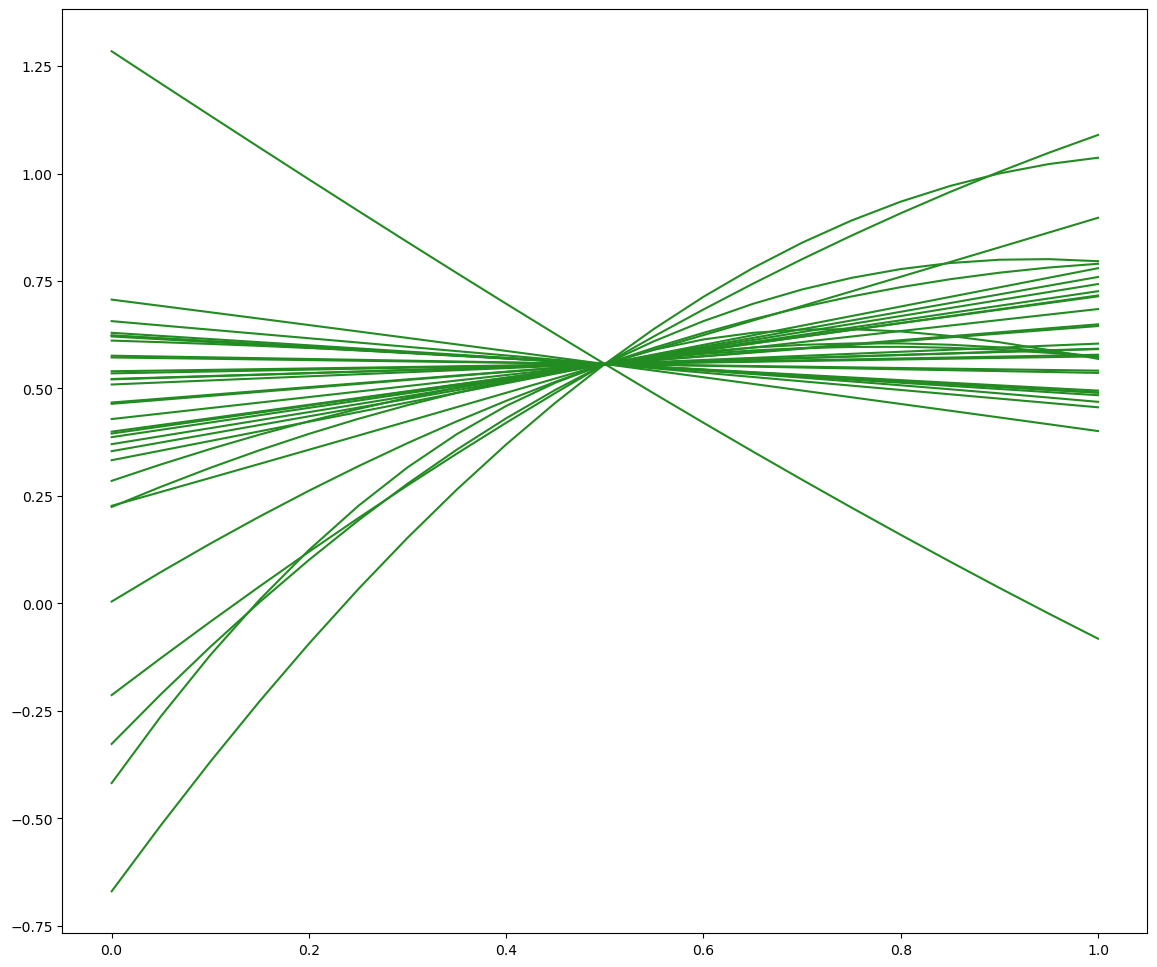

In [14]:
plt.figure(figsize=[14,12])

sample = unif
for i, p in enumerate(ppe_params.columns):
    
    ax=plt.subplot(1,1,1)
    sample[p] = s
    oaat, sd = BM_GPP_emulator_dict['Boreal forest'].predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    #ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='forestgreen',label='NL')
    
#plt.savefig('../figs/param_sens/OAAT_sensitivity_PFT1-4-13_gmLAI.png',dpi=200)

In [35]:
BM_df = pd.DataFrame(BM_psets_e2sd,columns=ppe_params.columns)
BM_df.to_csv('exp1_e2sd_BiomeEmulators_psets.csv')
#np.savetxt("exp1_e2sd_BiomeEmulators_psets.csv", BM_psets_e2sd, delimiter = ",")

In [191]:
TE_df = pd.DataFrame(TE_psets_e2sd[TE_sets,:],columns=ppe_params.columns)
TE_df.to_csv('exp1_e2sd_TotalErrorEmulator_psets.csv')